In [1]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.special import erf, erfinv
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm

In [2]:
def to_unit_box(x, lb, ub):
  return (x-lb) / (ub - lb)

def from_unit_box(x, lb, ub):
  return lb + (ub - lb) * x

def to_normed(y):
  avg, std = y.mean(), y.std()
  data_y = (y - avg) / std

  return data_y, avg, std

def from_normed(y, avg, std):
  return avg + std * y

def trunc_normal(rng, avg, std, a, b, size):
  if len(avg.shape) > 1:
    avg = avg[0]

  if len(std.shape) > 1:
    std = std[0]

  if len(a.shape) > 1:
    a = a[0]

  if len(b.shape) > 1:
    b = b[0]

  sqrt_2 = 1.4142135623730951
  lb = (1 + erf(((a-avg)/std)/sqrt_2, dtype=np.float32))/2
  ub = (1 + erf(((b-avg)/std)/sqrt_2, dtype=np.float32))/2

  tensor = 2*(rng.random(size=size, dtype=np.float32) * (ub - lb) + lb) - 1
  eps = np.finfo(tensor.dtype).eps

  tensor = np.clip(tensor, -(1.-eps), 1.-eps)

  tensor = erfinv(tensor, dtype=np.float32) * (sqrt_2 * std) + avg
  tensor = np.clip(tensor, a, b)

  return tensor

def phi_fn(evals_spent, n_evals):
  nds = [0.10, 0.10, 0.05, 0.025, 0.005, 0.005, 0, 0]
  val = nds[int(len(nds) * evals_spent / n_evals)]
  return val

def temp(k, n_evals, t_0=.1, t_K=1e-9):
  alpha = (t_K / t_0)**(1 / n_evals)
  t_k = alpha**(k) * t_0
  return np.array([t_k])

In [3]:
class RBF:
  def __init__(self, dim, lb, ub):
    self._dim = dim
    self._lb = lb
    self._ub = ub
    self._raw_x = np.empty((0, dim))
    self._raw_y = np.empty((0, 1))
    self._avg = None
    self._std = None
    self._lambda = None
    self._c = None

  def tell(self, x, y):

    self._raw_x = np.vstack((self._raw_x, x))
    self._raw_y = np.vstack((self._raw_y, y))

    data_x = to_unit_box(self._raw_x, self._lb, self._ub)
    data_y, self._avg, self._std = to_normed(self._raw_y)

    n, d = data_x.shape

    Phi = cdist(data_x, data_x) ** 3

    P = np.hstack((data_x, np.ones((n, 1))))
    O = np.zeros((d+1, d+1))
    A = np.vstack((np.hstack((Phi, P)), np.hstack((P.T, O))))
    B = np.vstack((data_y, np.zeros((d+1, 1))))

    # uncomment the following lines to see the dimensions of A and B
    # print(f'Shape of A is {A.shape}')
    # print(f'Shape of B is {B.shape}')

    if n > d + 1:
      W = np.linalg.solve(A, B)
    else:
      W = np.linalg.lstsq(A, B, rcond=None)[0]

    self._lambda = W[:n]
    self._c = W[n:]

    del A, B, O, P, Phi, W, data_x, data_y

  def ask(self, x):
    s_x = to_unit_box(x, self._lb, self._ub)
    data_x = to_unit_box(self._raw_x, self._lb, self._ub)

    Phi = cdist(s_x, data_x) ** 3

    tail_x = np.hstack((s_x, np.ones((s_x.shape[0], 1))))

    output = Phi @ self._lambda + tail_x @ self._c

    del tail_x, Phi, data_x, s_x

    s_y = from_normed(output, self._avg, self._std)

    return s_y

In [4]:
class Ackley:
    lb = -5.0
    ub = 10.0

    def __call__(self, x):
        """https://www.sfu.ca/~ssurjano/ackley.html
        `x` is a 2D np.array with shape (n_points x n_dimensions)."""
        if len(x.shape) < 2:
            x = x[None]
        dim_sqrt = np.sqrt([x.shape[1]])
        e = 2.7182817459106445
        a, b, c = 20.0, 0.2, 2 * 3.141592653589793
        part1 = -a * np.exp(-b / dim_sqrt * np.linalg.norm(x, axis=-1))
        part2 = -(np.exp(np.mean(np.cos(c * x), axis=-1)))
        y = part1 + part2 + a + e

        return y[:, None]

class Keane:
    lb = np.finfo(np.float32).eps
    ub = 10.0 - np.finfo(np.float32).eps

    def __call__(self, x):
        """ Keane's bump function, - to minimize
            https://mpra.ub.uni-muenchen.de/3098/1/MPRA_paper_3098.pdf
        """
        s1 = (np.cos(x)**4).sum(1)
        s2 = (np.cos(x)**2).prod(1)
        i = np.arange(x.shape[1]) + 1
        s3 = (i * x**2).sum(1)
        return - np.abs( (s1 - 2*s2) / np.sqrt(s3))[:, None]

  0%|          | 0/196 [00:00<?, ?it/s]

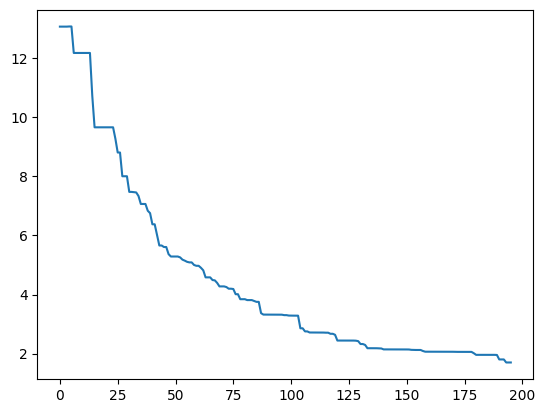

In [5]:
rng = np.random.default_rng(seed=2)
dim = 20
n_evals = 200
n_init = int(n_evals * .02)

f = Ackley()
f.ub = np.zeros(dim, dtype=np.float32) + f.ub
f.lb = np.zeros(dim, dtype=np.float32) + f.lb

t_norm = partial(trunc_normal,
                 rng=rng,
                 std=(f.ub - f.lb) / 6.0,
                 a=f.lb, b=f.ub)
T = partial(temp, n_evals=n_evals)
phi = partial(phi_fn, n_evals=n_evals)
eps = np.finfo(np.float32).eps

model = RBF(dim=dim, lb=f.lb, ub=f.ub)

x = rng.uniform(low=f.lb, high=f.ub, size=(n_init, dim))
y = f(x)

x_best = x[y.argmin()][None]
y_best = y[y.argmin()]

progress = []

for evals_spent in tqdm(range(n_init, n_evals)):
  progress.append(y_best.item())

  model.tell(x, y)
  p_select = phi(evals_spent)

  c = np.repeat(x_best, 10000, axis=0)
  mask = rng.random(size=c.shape) < p_select
  ind = np.where(mask.sum(1) == 0)[0]
  mask[ind, rng.integers(dim, size=ind.shape)] = True
  c[mask] = t_norm(avg=x_best, size=c.shape)[mask]

  s_y = model.ask(c)
  c_order = s_y.argsort(0)
  x = c[c_order[0]][:1]
  y = f(x)

  k = evals_spent
  u = rng.random()
  sa_p = np.exp((-(y-y_best) / T(k)).clip(np.log(eps), np.log(1)))
  if u < sa_p:
    x_best = x
    y_best = y

plt.plot(progress);

  0%|          | 0/392 [00:00<?, ?it/s]

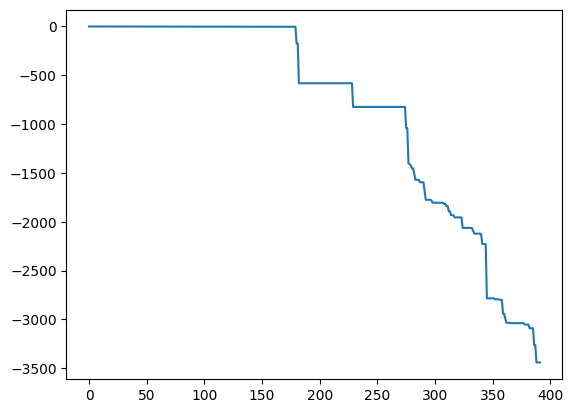

In [6]:
rng = np.random.default_rng(seed=2)
dim = 30
n_evals = 400
n_init = int(n_evals * .02)

f = Keane()
f.ub = np.zeros(dim, dtype=np.float32) + f.ub
f.lb = np.zeros(dim, dtype=np.float32) + f.lb

t_norm = partial(trunc_normal,
                 rng=rng,
                 std=(f.ub - f.lb) / 6.0,
                 a=f.lb, b=f.ub)
T = partial(temp, n_evals=n_evals)
phi = partial(phi_fn, n_evals=n_evals)
eps = np.finfo(np.float32).eps

model = RBF(dim=dim, lb=f.lb, ub=f.ub)

x = rng.uniform(low=f.lb, high=f.ub, size=(n_init, dim))
y = f(x)

x_best = x[y.argmin()][None]
y_best = y[y.argmin()]

progress = []

for evals_spent in tqdm(range(n_init, n_evals)):
  progress.append(y_best.item())

  model.tell(x, y)
  p_select = phi(evals_spent)

  c = np.repeat(x_best, 10000, axis=0)
  mask = rng.random(size=c.shape) < p_select
  ind = np.where(mask.sum(1) == 0)[0]
  mask[ind, rng.integers(dim, size=ind.shape)] = True
  c[mask] = t_norm(avg=x_best, size=c.shape)[mask]

  s_y = model.ask(c)
  c_order = s_y.argsort(0)
  x = c[c_order[0]][:1]
  y = f(x)

  k = evals_spent
  u = rng.random()
  sa_p = np.exp((-(y-y_best) / T(k)).clip(np.log(eps), np.log(1)))
  if u < sa_p:
    x_best = x
    y_best = y

plt.plot(progress);

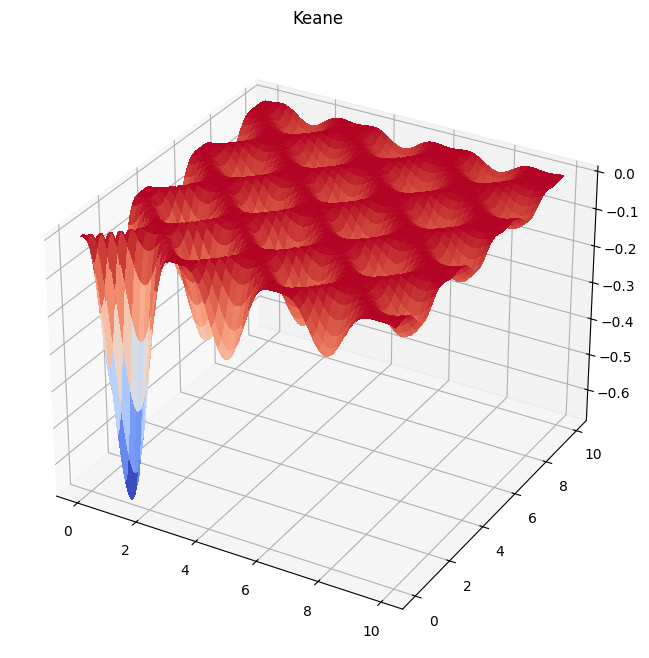

In [7]:
f = Keane()

fig, ax = plt.subplots(figsize=(8,8), subplot_kw={"projection": "3d"})

X = np.arange(f.lb, f.ub, .05)
Y = np.arange(f.lb, f.ub, .05)
X, Y = np.meshgrid(X, Y)

Z = f(np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))).reshape(X.shape)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, antialiased=False)
ax.set_title('Keane');

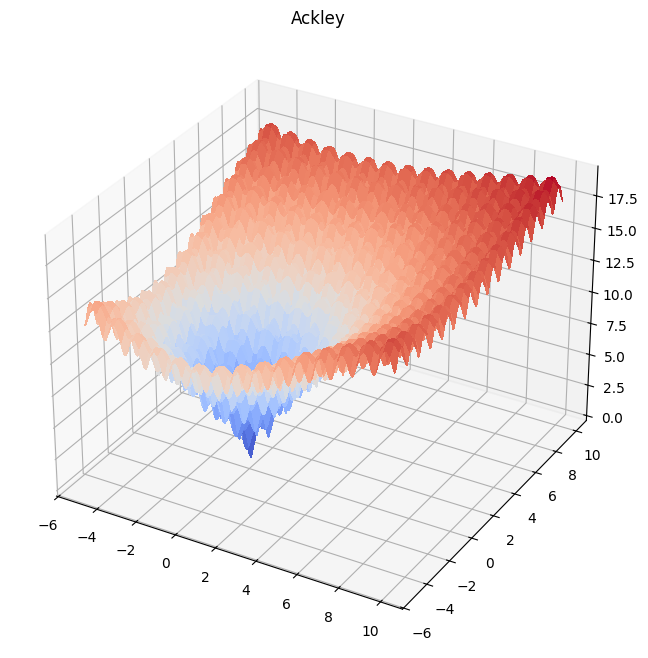

In [8]:
f = Ackley()

fig, ax = plt.subplots(figsize=(8,8), subplot_kw={"projection": "3d"})

X = np.arange(f.lb, f.ub, .05)
Y = np.arange(f.lb, f.ub, .05)
X, Y = np.meshgrid(X, Y)

Z = f(np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))).reshape(X.shape)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, antialiased=False)
ax.set_title('Ackley');